<a href="https://colab.research.google.com/github/sazzeb/simulated-annealing/blob/main/Part_B_Projects_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import math
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np


In [ ]:

def heuristic(network, sink):
    return sum(flow for (u, v), flow in network['flow'].items() if v == sink)



In [ ]:
def generate_paths(graph, source, sink):
    paths = []
    def dfs(curr, path):
        if curr == sink:
            paths.append(path[:])
            return
        for neighbor in graph['edges'].get(curr, []):
            if neighbor not in path:
                path.append(neighbor)
                dfs(neighbor, path)
                path.pop()
    dfs(source, [source])
    return paths


In [ ]:

def conservation_valid(temp_flow, graph, path, source, sink):
    for node in path[1:-1]:
        inflow = sum(temp_flow.get((u, node), 0) for u in graph['edges'])
        outflow = sum(temp_flow.get((node, v), 0) for v in graph['edges'].get(node, []))
        if inflow != outflow:
            return False
    return True


In [ ]:
def successor(network, graph, paths, source, sink):
    path = random.choice(paths)
    inc_flow = min(
        graph['capacity'][(path[i], path[i+1])] - network['flow'].get((path[i], path[i+1]), 0)
        for i in range(len(path)-1)
    )
    if inc_flow > 0:
        temp_flow = network['flow'].copy()
        for i in range(len(path)-1):
            u, v = path[i], path[i+1]
            temp_flow[(u, v)] = temp_flow.get((u, v), 0) + inc_flow
        for node in reversed(path[1:-1]):  # Exclude sink and source
            inflow = sum(temp_flow.get((u, node), 0) for u in graph['edges'] if (u, node) in temp_flow)
            outflow_edges = graph['edges'].get(node, [])
            outflow = sum(temp_flow.get((node, v), 0) for v in outflow_edges)
            # If mismatch, scale all outgoing flows to match inflow
            if outflow > inflow and outflow > 0:
                scale = inflow / outflow if outflow != 0 else 0
                for v in outflow_edges:
                    if (node, v) in temp_flow:
                        temp_flow[(node, v)] *= scale
        # Now, temp_flow is conservation-law corrected
        new_network = {'capacity': graph['capacity'], 'flow': temp_flow}
        return new_network, path, inc_flow
    return network, path, 0


In [ ]:
# c) Driver algorithm
def simulated_annealing(graph, source, sink, T_init=100, alpha=0.995, max_iter=1000):
    network = {'capacity': graph['capacity'], 'flow': {edge: 0 for edge in graph['capacity']}}
    paths = generate_paths(graph, source, sink)
    T = T_init
    current_value = heuristic(network, sink)

    best_network = {'capacity': network['capacity'], 'flow': network['flow'].copy()}
    best_value = current_value
    for iteration in range(max_iter):
        successor_net, path, inc_flow = successor(network, graph, paths, source, sink)
        next_value = heuristic(successor_net, sink)
        delta = next_value - current_value
        if delta > 0 or random.uniform(0, 1) < math.exp(delta / T):
            network = {'capacity': successor_net['capacity'], 'flow': successor_net['flow'].copy()}
            current_value = next_value
            if next_value > best_value:
                best_network = {'capacity': network['capacity'], 'flow': network['flow'].copy()}
                best_value = next_value
        T *= alpha
        if T < 1e-5:
            break
    return best_network, best_value

In [ ]:
def visualize_network_custom_r1(network, graph, sink):
    # Custom positions (adjust coordinates according to your expected diagram)
    node_pos = {
        0: (0, 1),     # Source
        1: (1, 2),
        2: (1, 0),
        3: (2, 1.5),
        4: (2, -0.5),
        29: (3, 1)     # Sink
    }

    G = nx.DiGraph()

    # print(node_pos)
    for (u, v), cap in graph['capacity'].items():
        flow = network['flow'].get((u, v), 0)
        G.add_edge(u, v, capacity=cap, flow=flow)

    nx.draw_networkx_nodes(G, node_pos, node_color='lightblue', node_size=1200, edgecolors='k', linewidths=1.5)
    nx.draw_networkx_labels(G, node_pos, font_size=16)
    nx.draw_networkx_edges(G, node_pos, arrowstyle='-|>', arrowsize=25, width=2, edge_color='gray')
    edge_labels = {(u, v): f"{G[u][v]['flow']}, {G[u][v]['capacity']}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(
        G, node_pos, edge_labels=edge_labels,
        font_size=14, font_color='red',
    )
    # plt.tight_layout()
    plt.title(f"Flow per edge (sink={sink})", fontsize=18)
    plt.axis('off')
    plt.show()


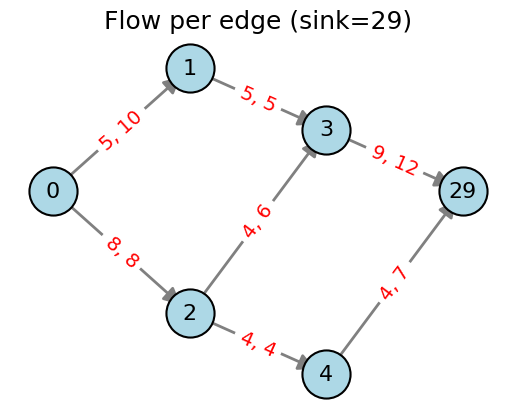

In [ ]:
# R1: Hardcoded graph (customize to match Figure 1 from Purpose.docx)
graph_r1 = {
    'edges': {0: [1,2], 1: [3], 2: [3,4], 3: [29], 4: [29]},
    'capacity': {(0,1):10, (0,2):8, (1,3):5, (2,3):6, (2,4):4, (3,29):12, (4,29):7}
}
source_r1, sink_r1 = 0, 29

network_r1, tf_r1 = simulated_annealing(graph_r1, source_r1, sink_r1)
# print(f"Signal annealing {network_r1}")
visualize_network_custom_r1(network_r1, graph_r1, sink_r1)

# visualize_network(network_r1, graph_r1, sink_r1)

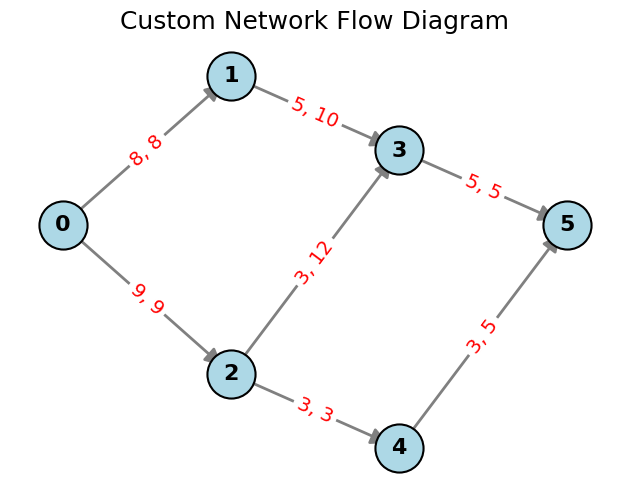

In [ ]:

def visualize_network(network, graph, sink):
    G = nx.DiGraph()
    for (u, v), cap in graph['capacity'].items():
        flow = network['flow'].get((u, v), 0)
        G.add_edge(u, v, capacity=cap, flow=flow)
    pos = nx.kamada_kawai_layout(G)
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=1200, edgecolors='k', linewidths=1.5)
    nx.draw_networkx_labels(G, pos, font_size=16, font_weight='bold')
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=25, width=2, edge_color='gray')
    edge_labels = {(u, v): f"{G[u][v]['flow']}, {G[u][v]['capacity']}" for u, v in G.edges()}
    nx.draw_networkx_edge_labels(
        G, pos, edge_labels=edge_labels,
        font_size=14, font_color='red', bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0.2')
    )
    plt.tight_layout()
    plt.title(f"Flow per edge (sink={sink})", fontsize=18)
    plt.axis('off')
    plt.show()


R2: Total flow into sink node by SA (tf): 4
R2: Total flow into sink node by Edmonds-Karp (tf_net): 4


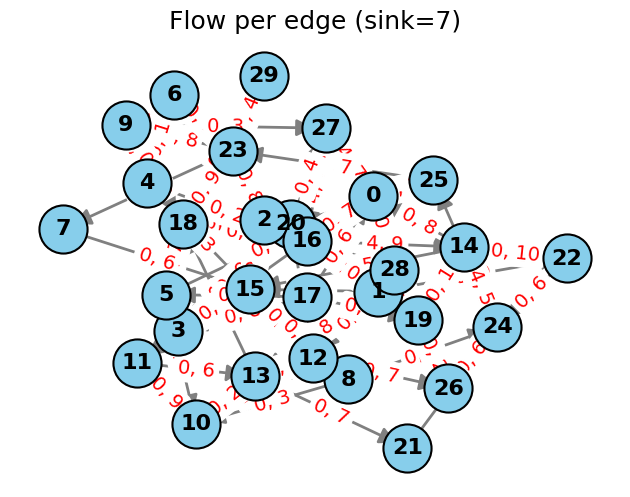

In [ ]:
num_nodes = 30
prob = 0.1
source_r2, sink_r2 = 0, 7

G = nx.gnp_random_graph(num_nodes, prob, directed=True)
G.remove_edges_from(nx.selfloop_edges(G))
for u, v in G.edges():
    G[u][v]['capacity'] = random.randint(1, 10)
graph_r2 = {
    'edges': {u: [] for u in G.nodes()},
    'capacity': {}
}
for u, v in G.edges():
    graph_r2['edges'][u].append(v)
    graph_r2['capacity'][(u, v)] = G[u][v]['capacity']

network_r2, tf_r2 = simulated_annealing(graph_r2, source_r2, sink_r2)
print("R2: Total flow into sink node by SA (tf):", tf_r2)
tf_net_r2 = nx.maximum_flow_value(G, source_r2, sink_r2, flow_func=nx.algorithms.flow.edmonds_karp)
print("R2: Total flow into sink node by Edmonds-Karp (tf_net):", tf_net_r2)
visualize_network(network_r2, graph_r2, sink_r2)

In [ ]:
def sa_average_flow_over_graphs(num_graphs=30, temp=100, num_nodes=30, prob=0.1, source=0, sink=7):
    flows = []
    for k in range(num_graphs):
        G = nx.gnp_random_graph(num_nodes, prob, directed=True)
        G.remove_edges_from(nx.selfloop_edges(G))
        for u, v in G.edges():
            G[u][v]['capacity'] = random.randint(1, 10)
        graph = {
            'edges': {u: [] for u in G.nodes()},
            'capacity': {}
        }
        for u, v in G.edges():
            graph['edges'][u].append(v)
            graph['capacity'][(u, v)] = G[u][v]['capacity']

        # Only run SA if a real path exists from source to sink
        paths = generate_paths(graph, source, sink)
        if not paths:  # No valid path
            flows.append(0)
            continue

        _, flow = simulated_annealing(graph, source, sink, T_init=temp)
        flows.append(flow)
    return np.mean(flows)


In [ ]:
# R3a: Average flow with T=100
tf_net_avg_100 = sa_average_flow_over_graphs(num_graphs=30, temp=100)
print("R3a: Average flow into sink node, T=100:", tf_net_avg_100)

# R3b: Average flow with T=1000
tf_net_avg_1000 = sa_average_flow_over_graphs(num_graphs=30, temp=1000)
print("R3b: Average flow into sink node, T=1000:", tf_net_avg_1000)

# R3c: Interpretation
if abs(tf_net_avg_1000 - tf_net_avg_100) / max(tf_net_avg_100, 1e-6) > 0.05:
    print("There is a significant difference between tf_net_avg(100) and tf_net_avg(1000).")
    print("Higher initial temperature allows broader exploration and can help escape local optima, potentially yielding higher flow values.")
else:
    print("No significant difference between tf_net_avg(100) and tf_net_avg(1000).")
    print("This may occur because the problem landscape is simple enough that both temperatures adequately explore and find good solutions, or the SA schedule/cooling is already sufficiently expressive.")


R3a: Average flow into sink node, T=100: 6.4
R3b: Average flow into sink node, T=1000: 6.166666666666667
No significant difference between tf_net_avg(100) and tf_net_avg(1000).
This may occur because the problem landscape is simple enough that both temperatures adequately explore and find good solutions, or the SA schedule/cooling is already sufficiently expressive.
